<a href="https://colab.research.google.com/github/bubriks/ID2223/blob/main/Project/project-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Course Project: Scalable Machine Learning and Deep Learning**

## **Paolo Teta & Ralfs Zangis**
---

# **Requirements**

**Spark**

In [1]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder.getOrCreate()

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 46.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=c1aa21514e946fe9c7680c002a2619c37dd88c7e2d85dba1ee87ea84a31f0ae4
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


**Tensorflow**

In [2]:
import tensorflow as tf

from tensorflow import keras

**Other**

In [3]:
import numpy as np
import matplotlib.pyplot as plt

**Mount Google Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
# **1. Get the data**

**Link:** https://drive.google.com/file/d/1Du-gZz1LU-StWbahzckG1EmSLC-FuW5S/view?usp=sharing

In [7]:
schema = StructType([
    StructField("emotion", IntegerType(), True),
    StructField("pixels", StringType(), True),
    StructField("Usage", StringType(), True)])

data = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/dataset-project.csv", header=True, schema=schema)
data = data.withColumn("id",monotonically_increasing_id())
data = data.withColumn("pixels",split(col("pixels")," ").cast("array<int>"))

---
# **2. Look at the data**

In [8]:
data.printSchema()
print((data.count(), len(data.columns)))

root
 |-- emotion: integer (nullable = true)
 |-- pixels: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Usage: string (nullable = true)
 |-- id: long (nullable = false)

(35887, 4)


In [9]:
data.show(5)

+-------+--------------------+--------+---+
|emotion|              pixels|   Usage| id|
+-------+--------------------+--------+---+
|      0|[70, 80, 82, 72, ...|Training|  0|
|      0|[151, 150, 147, 1...|Training|  1|
|      2|[231, 212, 156, 1...|Training|  2|
|      4|[24, 32, 36, 30, ...|Training|  3|
|      6|[4, 0, 0, 0, 0, 0...|Training|  4|
+-------+--------------------+--------+---+
only showing top 5 rows



In [10]:
data.filter(col("emotion") == 0).count()

4953

In [11]:
data.select("Usage").distinct().collect()

[Row(Usage='Training'), Row(Usage='PublicTest'), Row(Usage='PrivateTest')]

In [12]:
data.groupBy(col("emotion")).count().sort(asc("emotion")).show()

+-------+-----+
|emotion|count|
+-------+-----+
|      0| 4953|
|      1|  547|
|      2| 5121|
|      3| 8989|
|      4| 6077|
|      5| 4002|
|      6| 6198|
+-------+-----+



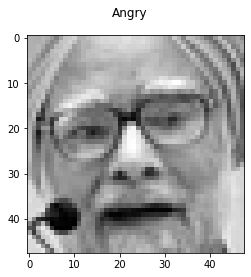

In [17]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

dataId = 1

row = data.filter(col("id") == dataId).first()
plt.figure(dataId)
pixelArray = np.asarray(row["pixels"])
plt.suptitle(emotion_labels[row["emotion"]])
plt.imshow(pixelArray.reshape((48, 48)), interpolation='none', cmap='gray')

---
# **3. Prediction**

In [18]:
train_set = data.filter(col("Usage") == "Training")
val_set = data.filter(col("Usage") == "PublicTest")
test_set = data.filter(col("Usage") == "PrivateTest")

In [19]:
%matplotlib notebook

import cv2
import matplotlib.pyplot as plt
import signal

In [20]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

In [24]:
vc = cv2.VideoCapture(0)

plt.ion()

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False
while is_capturing:
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview.set_data(frame)
    plt.draw()

    try:    # Avoids a NotImplementedError caused by `plt.pause`
        plt.pause(0.05)
    except Exception:
        pass
    if is_interrupted:
        vc.release()
        break